In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn
%matplotlib inline

In [245]:
df = pd.read_csv("rundbfills.csv")
df["time_total"] = [datetime.timedelta(seconds=duration) for duration in df["time_total"]]
df["endtime_formatted"] = [datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S") for timestamp in df["timestamp"]]
df["starttime_formatted"] = [endtime - duration for endtime, duration in zip(df["endtime_formatted"], df["time_total"])]

In [246]:
dmshiftstarts_moritz = [("2015-09-08", "night"),
                        ("2015-09-09", "night"),
                        ("2015-09-10", "night"),
                        ("2015-09-14", "morning"),
                        ("2015-09-15", "morning"),
                        ("2015-09-16", "evening"),
                        ("2015-09-17", "evening"),
                        ("2015-09-18", "night"),
                        ("2015-09-19", "night"),
                        ("2015-09-20", "night")]

dmshiftstarts_alex = [("2015-09-16", "morning"),
                      ("2015-09-17", "morning"),
                      ("2015-09-18", "morning"),
                      ("2015-09-19", "morning"),
                      ("2015-09-20", "morning"),
                      ("2015-09-21", "evening")]

dmshiftstarts_timon = [("2015-09-09", "morning"),
                       ("2015-09-10", "morning"),
                       ("2015-09-11", "evening"),
                       ("2015-09-12", "evening"),
                       ("2015-09-13", "evening"),
                       ("2015-09-14", "night")]

daytimetitle_daytime_dict = {"morning":"06:30:00", "evening":"14:30:00", "night":"22:30:00"}

shift_duration = (8,0,0) #hours, minutes, seconds
shift_duration = datetime.timedelta(hours=shift_duration[0], minutes=shift_duration[1], seconds=shift_duration[2])

In [247]:
def format_shift(shifts, translator=daytimetitle_daytime_dict):
    return [datetime.datetime.strptime(shift[0]+" {0}".format(translator[shift[1]]), "%Y-%m-%d %H:%M:%S") for shift in shifts]

def time_overlap(ti_1, ti_2):
    if ti_1[1]>=ti_2[0] and ti_2[1]>=ti_1[0]:
        if ti_1[0] <= ti_2[0] <= ti_1[1]: start = ti_2[0]
        else: start = ti_1[0]
        stop = min(ti_1[1], ti_2[1])
        return abs(start-stop)
    else: return datetime.timedelta(hours=0)

def check_for_matching_time(df, shifs, shift_dur):
    shift_time = []
    run_time = []
    total_lumi = []
    logged_lumi = []
    inefficiency = []
    deadtime = []
    for start_shift in format_shift(shifs):
        shift_time.append(shift_dur)
        for cnt, (start_run, end_run) in enumerate(zip(df["starttime_formatted"], df["endtime_formatted"])):
            temptime = time_overlap([start_run, end_run], [start_shift, start_shift + shift_dur])
            if temptime: 
                run_time.append(temptime)
                total_lumi.append(temptime/df["time_total"][cnt]*df["lumi_total"][cnt])
                logged_lumi.append(temptime/df["time_total"][cnt]*df["lumi_logged"][cnt])
                #print "start_run={0}, end_run={1}, start_shift={2}, dur={3}".format(start_run, end_run, start_shift, temptime)
    return (run_time, shift_time, total_lumi, logged_lumi)
            
def timedelta_sum(timedeltas):
    time_sum = datetime.timedelta(0)
    for timedelta in timedeltas:
        time_sum = time_sum + timedelta
    return time_sum
    
def show_shift_efficiency(runtime, shifttime, name=""):
    appendix = "'s" if name[-1] in ["x", "s", "z"] else "s"
    print "{0} shift efficiency: {1}%. " \
          "Time data taking: {2}".format(name+appendix, 
                                         round(timedelta_sum(runtime)/timedelta_sum(shifttime),2), 
                                         timedelta_sum(runtime))    
        
#  stolen from http://stackoverflow.com/questions/8906926/formatting-python-timedelta-objects  
def strfdelta(tdelta, fmt):
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

In [248]:
class Shifter(dict):
    def __init__(self, **kwargs):
        self["name"] = kwargs.pop("name", "John Doe")
        self["dlumi"] = sum(kwargs.pop("dlumi", [0.0]))/1e6 #pb^-1
        self["clumi"] = sum(kwargs.pop("clumi", [0.0]))/1e6 #pb^-1
        self["runtime"] = kwargs.pop("runtime", [datetime.timedelta(hours=0)])
        self["shifttime"] = kwargs.pop("shifttime", [datetime.timedelta(hours=0)])
        self["digits"] = kwargs.pop("digits", 2)
        self["shifteff"] = timedelta_sum(self["runtime"])/timedelta_sum(self["shifttime"])
        self["ineff"] = self["clumi"]/self["dlumi"]
        
        self["runtime"] = timedelta_sum(self["runtime"])
        self["shifttime"] = timedelta_sum(self["shifttime"])
        
        
    def get_name(self):
        return self["Name"]
    
    def get_dlumi(self):
        return self["dlumi"]
    
    def get_clumi(self):
        return self["clumi"]
    
    def get_runtime(self):
        return self["runtime"]
    
    def get_shifttime(self):
        return self["shifttime"]
    
    def get_shifteff(self):
        return self["shifteff"]
    
    def get_ineff(self):
        return self["ineff"]
    
    def describe(self):
        print "Name: {0}\nTotal time shifted: {1}," \
        " time in stable beams condition: {2} ({3}%)" \
        "\nDelivered Lumi: {4} pb^-1, collected Lumi: {5} pb^-1 ({6}%)\n".format(self["name"],
                                                                  str(self["shifttime"]).split(".")[0],
                                                                  str(self["runtime"]).split(".")[0], 
                                                                  round(self["shifteff"]*100,self["digits"]), 
                                                                  round(self["dlumi"],self["digits"]),
                                                                  round(self["clumi"],self["digits"]),
                                                                  round(self["ineff"]*100,self["digits"]))

In [249]:
runtime_alex, shifttime_alex, totlumi_alex, loglumi_alex = check_for_matching_time(df, dmshiftstarts_alex, shift_duration)
runtime_timon, shifttime_timon, totlumi_timon, loglumi_timon = check_for_matching_time(df, dmshiftstarts_timon, shift_duration)
runtime_moritz, shifttime_moritz, totlumi_moritz, loglumi_moritz = check_for_matching_time(df, dmshiftstarts_moritz, shift_duration)

In [250]:
alex = Shifter(name="Alex",
               dlumi=totlumi_alex,
               clumi=loglumi_alex,
               runtime=runtime_alex, 
               shifttime=shifttime_alex)

timon = Shifter(name="Timon",
               dlumi=totlumi_timon,
               clumi=loglumi_timon,
               runtime=runtime_timon, 
               shifttime=shifttime_timon)

moritz = Shifter(name="Moritz",
               dlumi=totlumi_moritz,
               clumi=loglumi_moritz,
               runtime=runtime_moritz, 
               shifttime=shifttime_moritz)

timon.describe()
alex.describe()
moritz.describe()

Name: Timon
Total time shifted: 2 days, 0:00:00, time in stable beams condition: 0 days 20:20:33 (42.38%)
Delivered Lumi: 7.67 pb^-1, collected Lumi: 6.08 pb^-1 (79.35%)

Name: Alex
Total time shifted: 2 days, 0:00:00, time in stable beams condition: 0 days 19:43:38 (41.1%)
Delivered Lumi: 11.44 pb^-1, collected Lumi: 9.58 pb^-1 (83.7%)

Name: Moritz
Total time shifted: 3 days, 8:00:00, time in stable beams condition: 0 days 16:26:07 (20.54%)
Delivered Lumi: 8.57 pb^-1, collected Lumi: 7.08 pb^-1 (82.56%)



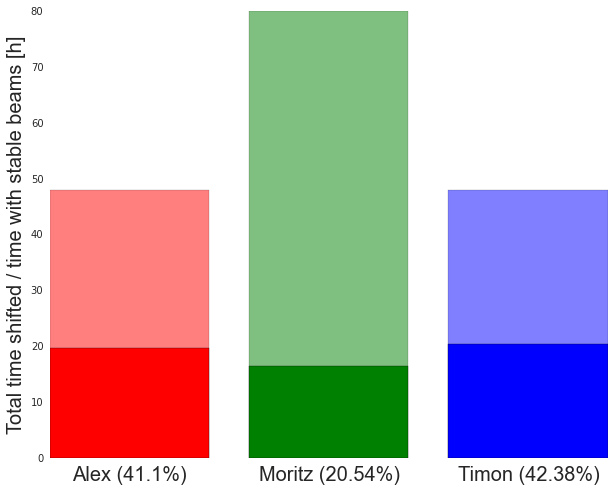

In [251]:
def configure_barchart(ylabel="default", names=("Alex", "Moritz", "Timon"), xticks=[0.5,1.5,2.5], appendix = ["", "", ""]):
    fig, ax = plt.subplots()
    new_names = [name+app for name, app in zip(names,appendix)]
    ax.set_ylabel(ylabel,fontsize=20)
    ax.set_xticks(xticks)
    ax.set_xticklabels(new_names, fontsize=20)
    fig.set_size_inches(10,8)
    return fig, ax
    
fig_shifttime, ax_shifttime = configure_barchart("Total time shifted / time with stable beams [h]", 
                                                  appendix=[" ({0}%)".format(round(alex.get_shifteff()*100,2)),
                                                            " ({0}%)".format(round(moritz.get_shifteff()*100,2)),
                                                            " ({0}%)".format(round(timon.get_shifteff()*100,2)),])

shifttime = [alex.get_shifttime().total_seconds()/3600., #time in h
             moritz.get_shifttime().total_seconds()/3600.,
             timon.get_shifttime().total_seconds()/3600.]

runtime = [  alex.get_runtime().total_seconds()/3600.,
             moritz.get_runtime().total_seconds()/3600.,
             timon.get_runtime().total_seconds()/3600.]

ax_shifttime.bar([0.1,1.1,2.1] , shifttime, color=['r','g','b'], alpha=0.5)
ax_shifttime.bar([0.1,1.1,2.1] , runtime, color=['r','g','b'])

plt.show()
fig_shifttime.savefig("shifttime.pdf")

[11.441559441662921, 8.5748477077198793, 7.6667133209859806]


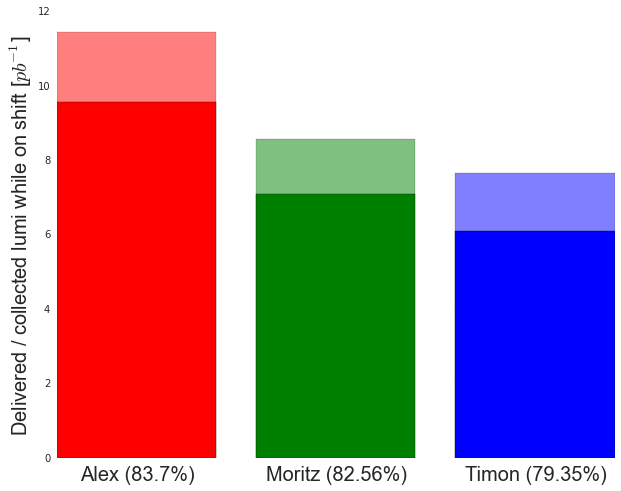

In [252]:
dellumi = [alex.get_dlumi(),
           moritz.get_dlumi(),
           timon.get_dlumi()]

print dellumi

collumi = [alex.get_clumi(),
           moritz.get_clumi(),
           timon.get_clumi()]

fig_lumi, ax_lumi = configure_barchart(r"Delivered / collected lumi while on shift [$pb^{-1}$]",
                                       appendix=[" ({0}%)".format(round(alex.get_ineff()*100,2)),
                                                " ({0}%)".format(round(moritz.get_ineff()*100,2)),
                                                " ({0}%)".format(round(timon.get_ineff()*100,2))])

ax_lumi.bar([0.1,1.1,2.1], dellumi, color=['r','g','b'], alpha=0.5)
ax_lumi.bar([0.1,1.1,2.1], collumi, color=['r','g','b'])

plt.show()
fig_lumi.savefig("coll_lumi.pdf")